In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
from emukit.core.initial_designs.random_design import RandomDesign
from emukit.core.initial_designs.latin_design import LatinDesign
from emukit.model_wrappers import GPyModelWrapper
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement, \
    NegativeLowerConfidenceBound, MaxValueEntropySearch

from utils import get_array_and_len, x_scaler, x_descaler, get_closest_array, \
    define_parameter_space, get_rbf_kernel, get_gpr_model, get_matern52_kernel, \
    generate_visualization_efficiency_vs_ml_conditions, generate_contour_plot, \
    generate_visualization_suggested_process_conditions, compute_group_means
from utils import ScaledProbabilityOfFeasibility, ProbabilisticConstraintBayesianOptimizationLoop2


np.random.seed(10)

In [2]:
# Assuming your data is in an Excel file named 'your_data.xlsx'.
file_path = './器件薄膜数据.xlsx'
sheet_name = '2022_07_15_film'

df_film = pd.read_excel(file_path, sheet_name=sheet_name)
print(df_film.columns)

# Renaming the columns
df_film.columns = ['Condition', 'NMP (mL)', 'DMF (mL)', 'DMSO (mL)', 'Perovskite concentration (M)',  'Annealing temperature (℃)', 'Vacuum Pressure (Pa)', 'Vacuum Pressure time (s)', 'Temperature (℃)', 'Humidity (%)', 'Success or Fail']

# Filter the successful conditions
success_conditions = df_film[df_film['Success or Fail'] == 1]['Condition'].values

# Display the DataFrame
#df_film

Index(['Condition', 'NMP(mL)', 'DMF(mL)', 'DMSO(mL)',
       'Perovskite concentration(M)', 'Annealing temperature(℃)',
       'Vacuum Pressure(Pa)', 'Vacuum Pressure time(s)', 'Temperature(℃)',
       'humidity(%)', 'Success or Fail'],
      dtype='object')


In [3]:
# Assuming your data is in an Excel file named 'your_data.xlsx' and the sheet name is '2022-device'.
file_path = './器件薄膜数据.xlsx'
sheet_name = '2022_07_15_device'

df_device = pd.read_excel(file_path, sheet_name=sheet_name)
print(df_device.columns)

df_device.columns = ['Condition', 'NMP (mL)', 'DMF (mL)', 'DMSO (mL)', 
                     'Perovskite concentration (M)', 'Annealing temperature (℃)', 
                     'Vacuum Pressure (Pa)', 'Vacuum Pressure time (s)', 
                     'Temperature (℃)', 'Humidity (%)', 'Voc(V)', 'FF(%)', 
                     'Eff(%)', 'Jsc(mA/cm^2)']
# Filter data based on success_conditions
success_conditions = [2, 4, 5, 6, 7, 8, 11, 12, 17, 18]
df_device = df_device.sort_values(by=list(df_device.iloc[:,[0,-1]].columns))
df_device = df_device[df_device['Condition'].isin(success_conditions)]

# take the mean of the measurements
df_device = compute_group_means(df_device)

# Display the DataFrame
df_device

Index(['Condition', 'NMP(mL)', 'DMF(mL)', 'DMSO(mL)',
       'Perovskite concentration(M)', 'Annealing temperature(℃)',
       'Vacuum Pressure(Pa)', 'Vacuum Pressure time(s)', 'Temperature(℃)',
       'humidity(%)', 'Voc (V)', 'FF (%)', 'Eff (%)', 'Jsc (mA/cm^2)'],
      dtype='object')


,Condition,NMP (mL),DMF (mL),DMSO (mL),Perovskite concentration (M),Annealing temperature (℃),Vacuum Pressure (Pa),Vacuum Pressure time (s),Temperature (℃),Humidity (%),Voc(V),FF(%),Eff(%),Jsc(mA/cm^2)
0,2,100,0,0,1.30,100,250,25,25,30,0.990840,68.372500,15.208100,24.929150
1,4,15,85,0,1.40,125,100,15,25,30,0.927814,72.167550,17.584025,25.371675
2,5,0,15,85,1.10,135,120,17,25,30,1.012060,73.626850,18.687275,25.437650
3,6,15,85,0,1.50,145,100,15,25,30,0.917055,64.097075,14.670875,25.018525
4,7,0,85,15,1.65,155,50,15,25,30,1.050000,76.610175,20.064050,25.129866
5,8,85,0,15,1.70,105,200,15,25,30,1.050000,65.892725,15.399400,23.619785
6,11,0,30,70,1.30,130,80,35,25,30,1.000000,71.424875,18.216725,25.224007
7,12,30,70,0,1.35,135,200,18,25,30,0.930592,39.721275,7.814825,24.626475
8,17,55,45,0,1.00,125,70,45,25,30,0.884523,61.404125,13.864700,24.951775
9,18,45,55,0,1.20,115,270,47,25,30,0.974575,62.769775,10.863735,23.247075


In [4]:
# Load the dataset
df_previous = pd.read_excel("./限制性数据.xlsx")

# Change the column names
df_previous.columns = [
    '',
    'NMP (mL)',
    'DMF (mL)',
    'DMSO (mL)',
    'Perovskite concentration (M)',
    'Annealing temperature (℃)',
    'Vacuum Pressure (Pa)',
    'Vacuum Pressure time (s)',
    'Temperature (℃)',
    'Humidity (%)',
    'Voc(V)',
    'FF(%)',
    'Eff(%)',
    'Jsc(mA/cm^2)'
]

# Remove the first column
df_previous = df_previous.iloc[:, 1:]

#df_previous

In [5]:
## Total process conditions: NMP x DMF x DMSO x PC x AT x VP x VT x T = 1871100000 conditions

NMP_min, NMP_max, NMP_step = [0, 50, 5] ## Unit: ml ## 10 steps
NMP_var, NMP_num = get_array_and_len(NMP_min, NMP_max, NMP_step)

DMF_min, DMF_max, DMF_step = [0, 100, 5] ## Unit: ml ## 50 steps
DMF_var, DMF_num = get_array_and_len(DMF_min, DMF_max, DMF_step)

DMSO_min, DMSO_max, DMSO_step = [0, 50, 5] ## Unit: ml ## 10 steps
DMSO_var, DMSO_num = get_array_and_len(DMSO_min, DMSO_max, DMSO_step)

PC_min, PC_max, PC_step = [0.8, 1.8, 0.1] ## Unit: M ## 10 steps
PC_var, PC_num = get_array_and_len(PC_min, PC_max, PC_step)

AT_min, AT_max, AT_step = [100, 170, 10] ## Unit: °C ## 7 steps
AT_var, AT_num = get_array_and_len(AT_min, AT_max, AT_step)

VP_min, VP_max, VP_step = [20, 350, 10] ## Unit: Pa ## 33 steps
VP_var, VP_num = get_array_and_len(VP_min, VP_max, VP_step)

VT_min, VT_max, VT_step = [5, 50, 5] ## Unit: s ## 9 steps
VT_var, VT_num = get_array_and_len(VT_min, VT_max, VT_step)

T_min, T_max, T_step = [15, 30, 5] ## Unit: °C ## 3 steps
T_var, T_num = get_array_and_len(T_min, T_max, T_step)

humidity_min, humidity_max, humidity_step = [15, 45, 5]  # Unit: [%] ## 6 steps
humidity_var, humidity_num = get_array_and_len(humidity_min, humidity_max, humidity_step)

var_array = [NMP_var, DMF_var,
DMSO_var, PC_var,
AT_var, VP_var,
VT_var, T_var, humidity_var]

In [6]:
from emukit.core.initial_designs.random_design import RandomDesign
from emukit.core.initial_designs.latin_design import LatinDesign

parameter_space = define_parameter_space(NMP_num, DMF_num, DMSO_num, PC_num, AT_num, \
                                         VP_num, VT_num, T_num, humidity_num)

In [7]:
# Preprocess your data
x_init = x_scaler(df_device.iloc[:, 1:10].values, var_array)
y_init = np.transpose([df_device.iloc[:, -2].values])
xc_init = x_scaler(df_film.iloc[:, 1:-1].values, var_array)
yc_init = np.transpose([df_film.iloc[:, -1].values])
X, Y, Xc, Yc = [x_init, y_init, xc_init, yc_init]

Xc2 = x_scaler(df_previous.iloc[:,0:9].values, var_array)
Yc2 = np.transpose([df_previous.iloc[:,-2].values])

# get objective model
input_dim = len(X[0])
ker = get_matern52_kernel(input_dim)
model_gpy = get_gpr_model(X, Y, ker, set_noise=True)
objective_model = GPyModelWrapper(model_gpy)

# get constraint model 1
input_dim_c = len(Xc[0])
ker_c = get_rbf_kernel(input_dim_c)
yc_offset = 0.5 # constraint acquisition computes the probability of <0
gpy_constraint_model = get_gpr_model(Xc, Yc-yc_offset, ker_c) 
constraint_model1 = GPyModelWrapper(gpy_constraint_model)

# get_constraint_model 2
input_dim_c2 = len(Xc2[0])
ker_c2 = get_rbf_kernel(input_dim_c2)
yc2_offset = np.mean(Yc2)  # constraint acquisition computes the probability of <0
gpy_constraint_model2 = get_gpr_model(Xc2, Yc2-yc2_offset, ker_c2) 
constraint_model2 = GPyModelWrapper(gpy_constraint_model2)

reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance
reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.variance
reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.variance


In [8]:
objective_model.model.kern.lengthscale

index,GP_regression.Mat52.lengthscale,constraints,priors
[0],1.00000000,"0.1,1.0",
[1],0.99999996,"0.1,1.0",
[2],1.00000000,"0.1,1.0",
[3],1.00000000,"0.1,1.0",
[4],1.00000000,"0.1,1.0",
[5],0.99999906,"0.1,1.0",
[6],1.00000000,"0.1,1.0",
[7],0.70273039,"0.1,1.0",
[8],0.38147985,"0.1,1.0",


# Start the First Run of the Batch-mode Bayesian Optimization

In [9]:
import numpy as np
## Expeceted Improvement (EI)
#acquisition = ExpectedImprovement(objective_model, jitter=.1)
## Lower Confidence Bound (LCB)
acquisition = NegativeLowerConfidenceBound(objective_model, beta = 1)

# Make loop and collect points
bayesopt_cons_pr = ProbabilisticConstraintBayesianOptimizationLoop2(model_objective=objective_model, 
                                                          space=parameter_space, 
                                                          acquisition=acquisition,
                                                          model_constraint1=constraint_model1,
                                                          model_constraint2=constraint_model2,
                                                          batch_size = 40)

X_new = bayesopt_cons_pr.candidate_point_calculator.compute_next_points(bayesopt_cons_pr.loop_state)
X_new = x_scaler(get_closest_array(x_descaler(X_new, var_array), var_array), var_array)

f_obj =  objective_model.model.predict       
f_cons1 = constraint_model1.model.predict
f_cons2 = constraint_model2.model.predict

f_cons_acq = bayesopt_cons_pr.candidate_point_calculator.acquisition.acquisition.evaluate
f_raw_acq = bayesopt_cons_pr.candidate_point_calculator.acquisition.acquisition.acquisition_1.evaluate
f_cons_pr = bayesopt_cons_pr.candidate_point_calculator.acquisition.acquisition.acquisition_2.evaluate

print('total condition no.:', len(Xc))
print('total device no.:', len(bayesopt_cons_pr.loop_state.Y))get
print('maximum Y (PCE [%]): ', -np.min(np.transpose(np.round(bayesopt_cons_pr.loop_state.Y, 2))))


total condition no.: 20
total device no.: 10
maximum Y (PCE [%]):  20.06


In [10]:
df_Xnew = pd.DataFrame(get_closest_array(x_descaler(X_new, var_array), var_array), columns = df_film.columns[1:10])
df_Xnew = df_Xnew.drop_duplicates(keep='first')
print(len(df_Xnew))

df_Xnew = df_Xnew[~df_Xnew.apply(tuple, axis=1).isin(df_film[df_film.columns[:10]].apply(tuple, axis=1))]
print(len(df_Xnew))

21
21


In [11]:
df_Xnew
#raise KeyError

,NMP (mL),DMF (mL),DMSO (mL),Perovskite concentration (M),Annealing temperature (℃),Vacuum Pressure (Pa),Vacuum Pressure time (s),Temperature (℃),Humidity (%)
0,0.0,85.0,10.0,1.4,130.0,80.0,20.0,25.0,30.0
1,0.0,85.0,10.0,1.5,120.0,90.0,20.0,25.0,30.0
2,0.0,85.0,10.0,1.4,120.0,70.0,20.0,25.0,30.0
3,0.0,25.0,50.0,1.2,120.0,20.0,5.0,25.0,30.0
4,5.0,85.0,10.0,1.4,110.0,60.0,25.0,25.0,30.0
5,0.0,85.0,15.0,1.5,120.0,70.0,20.0,25.0,30.0
6,0.0,85.0,10.0,1.5,120.0,70.0,20.0,25.0,30.0
7,0.0,90.0,15.0,1.5,120.0,70.0,20.0,25.0,30.0
8,45.0,55.0,5.0,1.3,110.0,70.0,35.0,25.0,30.0
9,0.0,85.0,15.0,1.4,120.0,80.0,20.0,25.0,30.0


In [18]:
X_new = x_scaler(df_Xnew.values, var_array)

y_pred_new, y_uncer_new = f_obj(X_new)
y_pred_new = -y_pred_new
y_uncer_new = np.sqrt(y_uncer_new)

acq_produc = f_cons_acq(X_new)
acq_fcn = f_raw_acq(X_new)
acq_cons = f_cons_pr(X_new)

[[0.99185648]
 [0.99075571]
 [0.98802233]
 [0.76580012]
 [0.979656  ]
 [0.98122343]
 [0.98733617]
 [0.97128412]
 [0.93882184]
 [0.98134405]
 [0.99124283]
 [0.98982092]
 [0.7733657 ]
 [0.9764501 ]
 [0.98495906]
 [0.84194383]
 [0.98264553]
 [0.98418127]
 [0.98920025]
 [0.98518057]
 [0.98586207]]


# Quick histogram visualization of the newly suggested process conditions

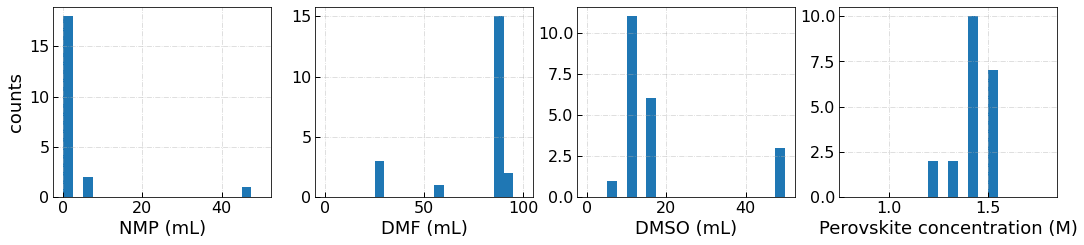

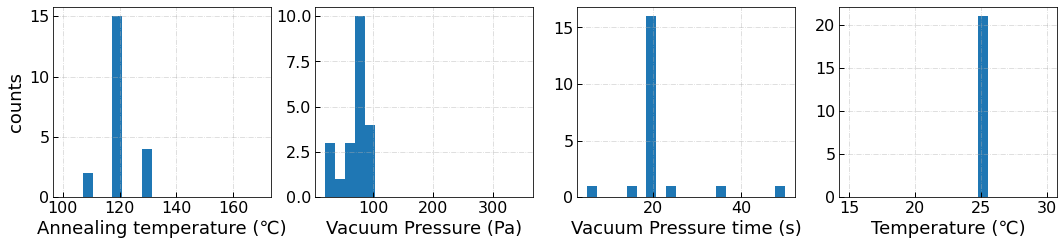

In [16]:
generate_visualization_suggested_process_conditions(df_Xnew, 4, var_array)

# Visualisation of Efficiency vs ML conditions, and Acquisition¶

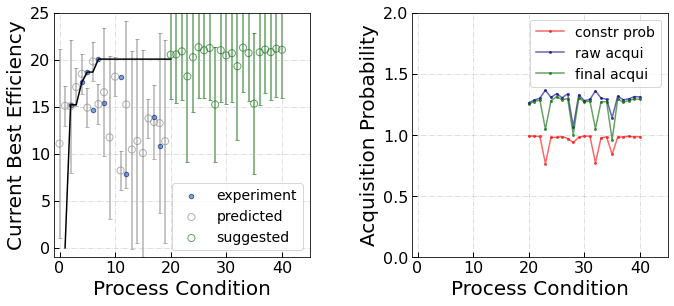

In [14]:
from emukit.core.initial_designs import RandomDesign

f_obj =  objective_model.model.predict       

generate_visualization_efficiency_vs_ml_conditions(X_new, Xc, df_device, df_film, f_obj, \
                                                   acq_fcn, acq_cons, acq_produc, var_array)

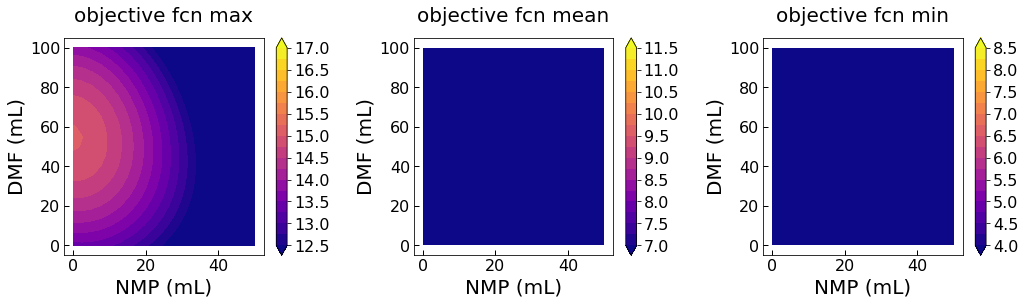

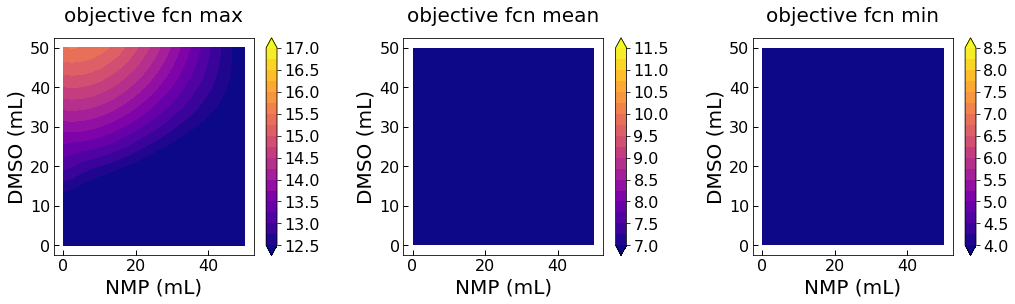

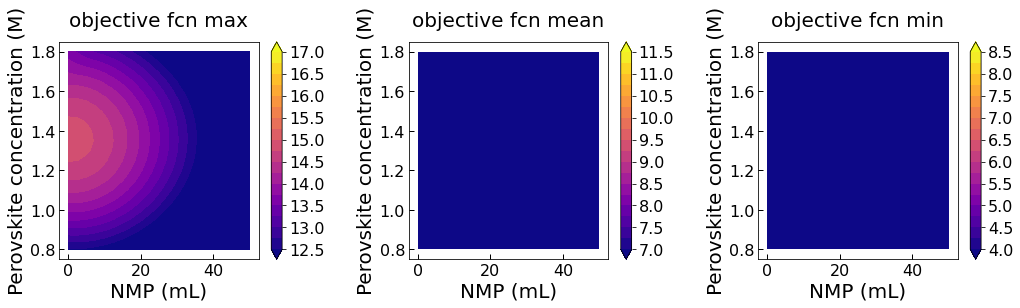

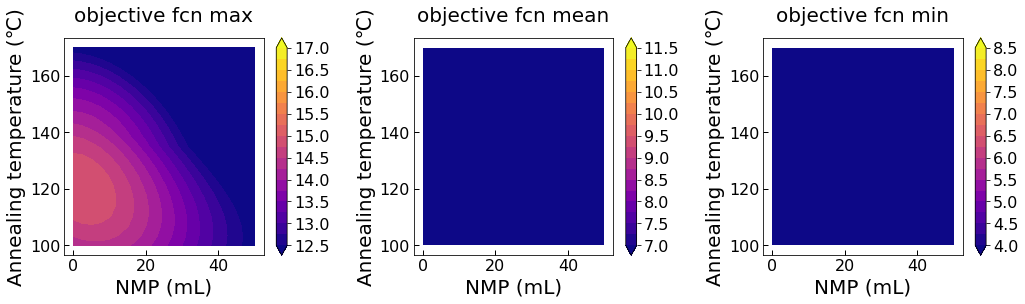

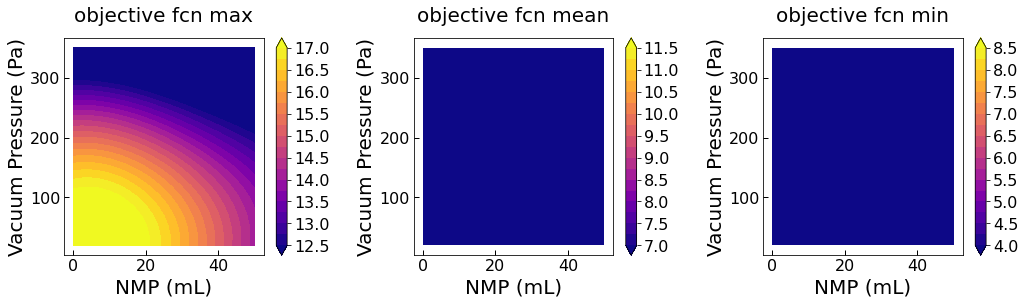

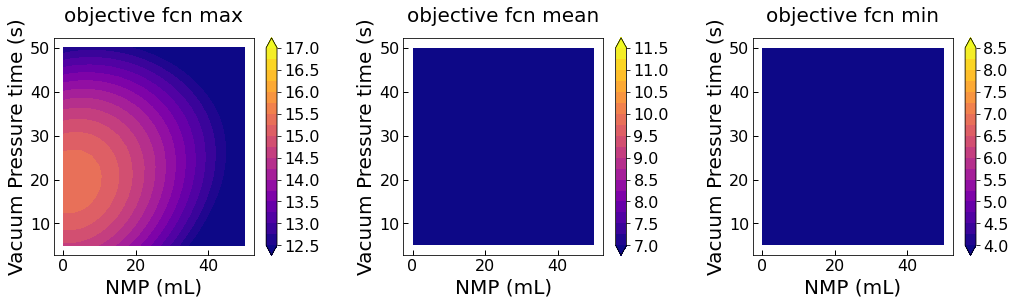

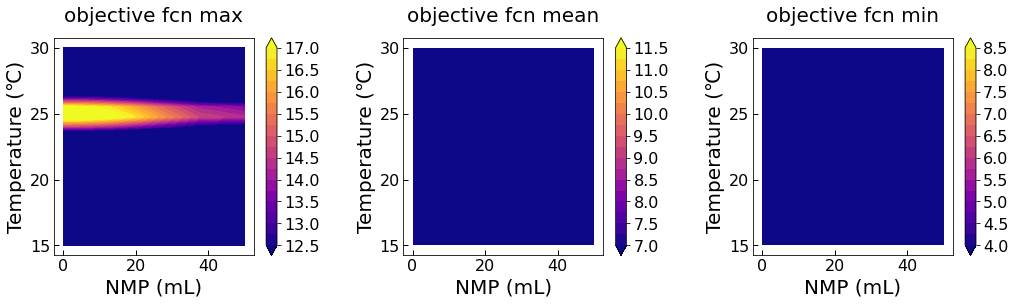

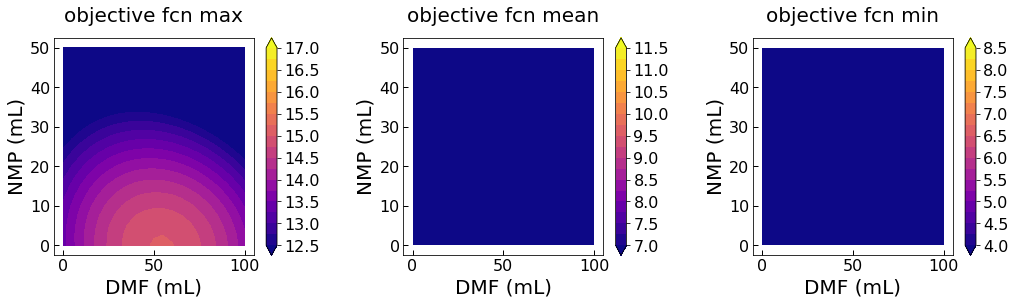

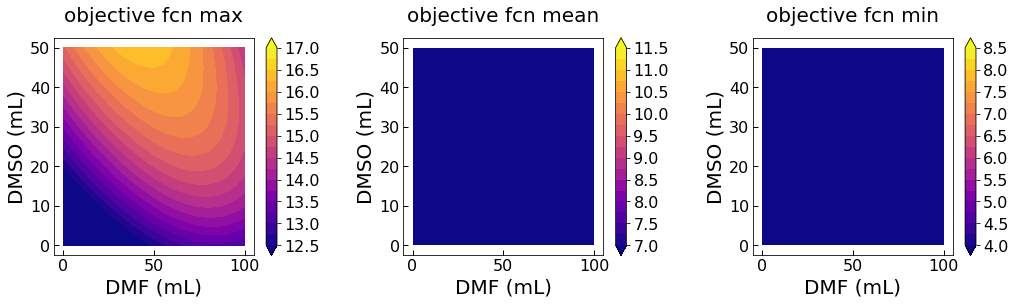

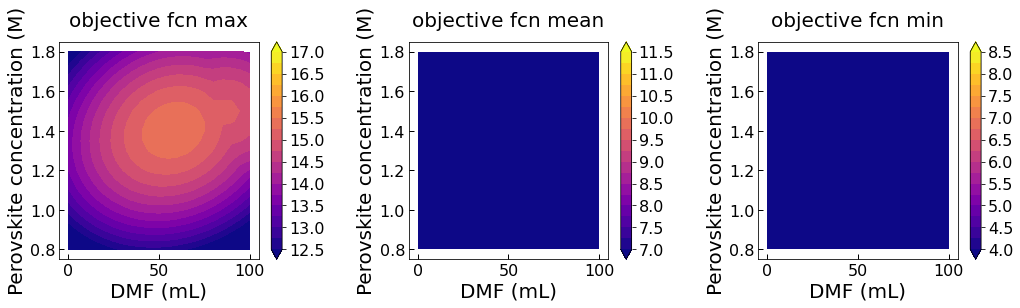

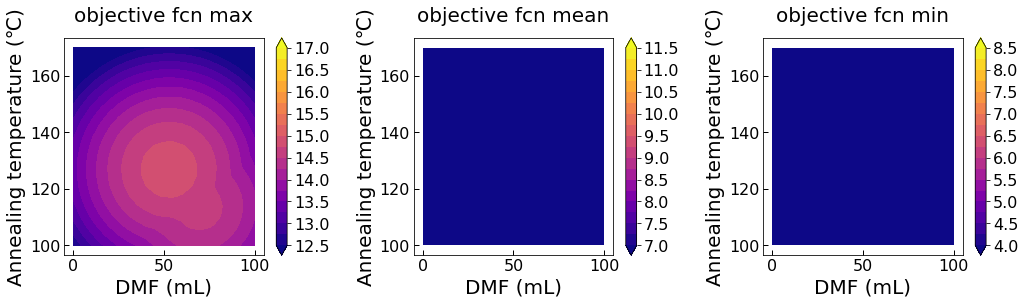

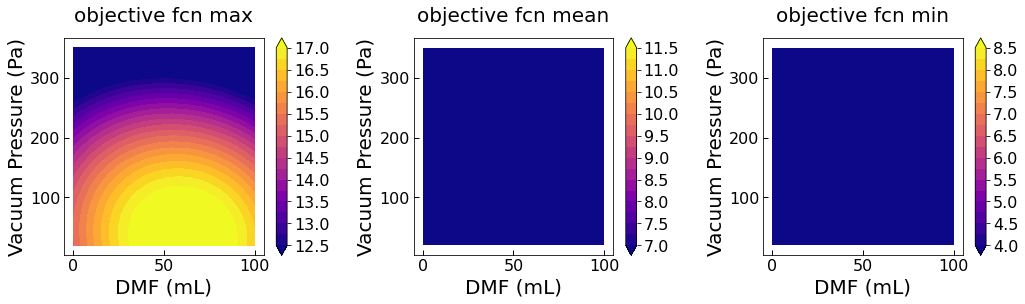

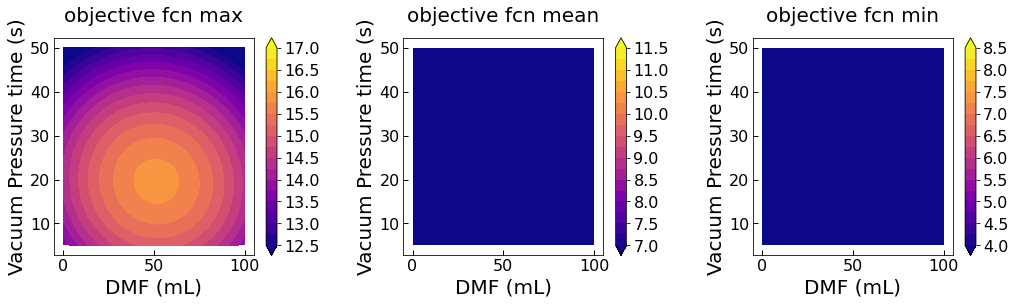

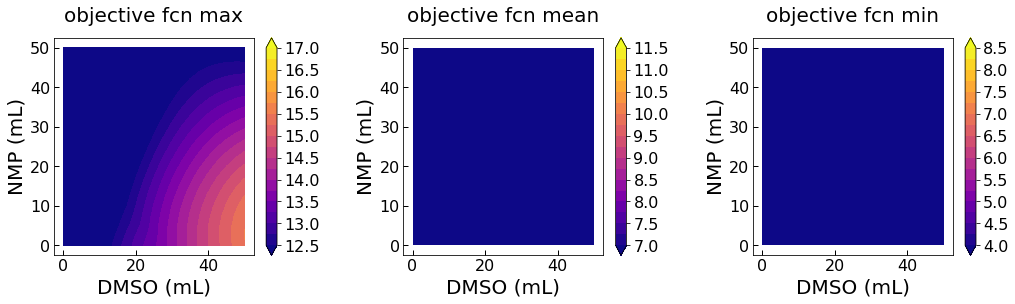

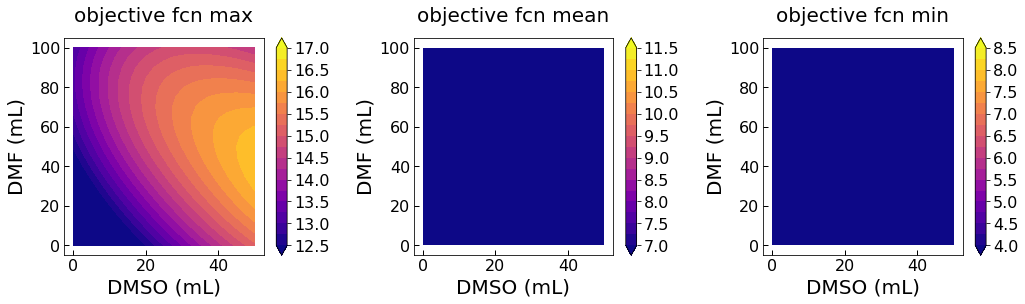

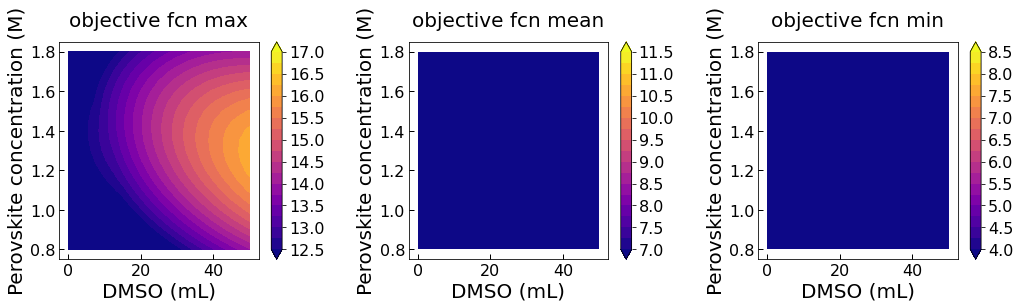

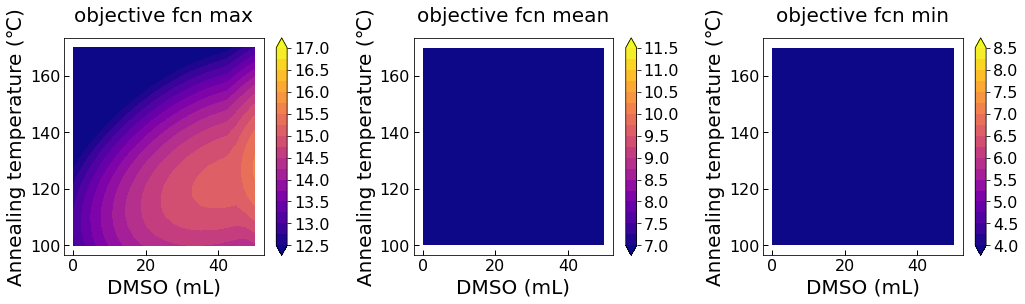

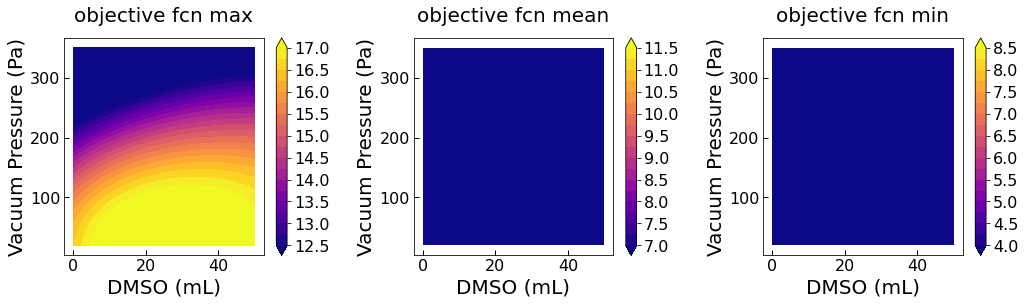

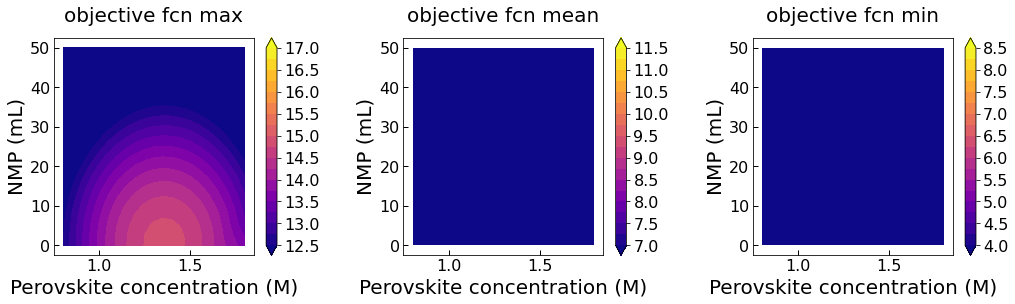

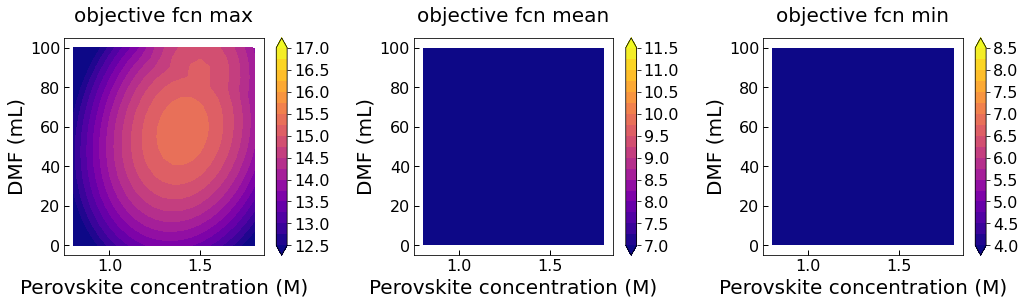

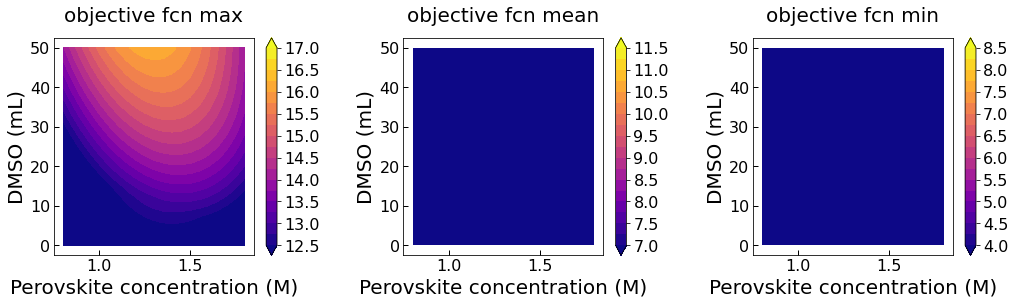

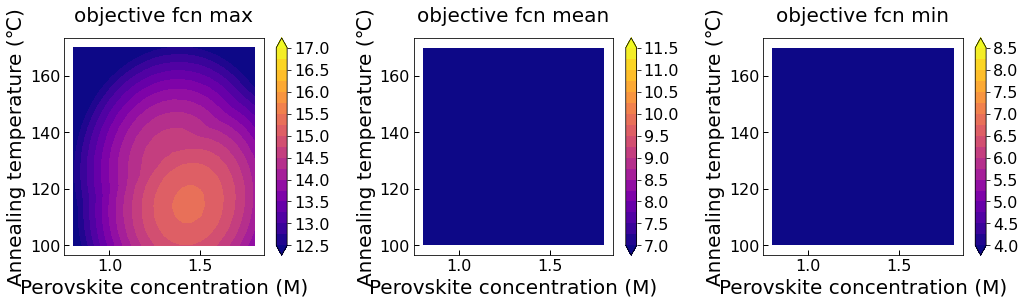

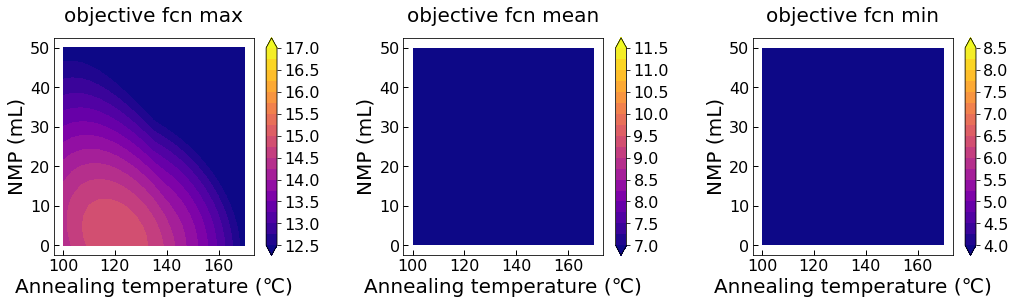

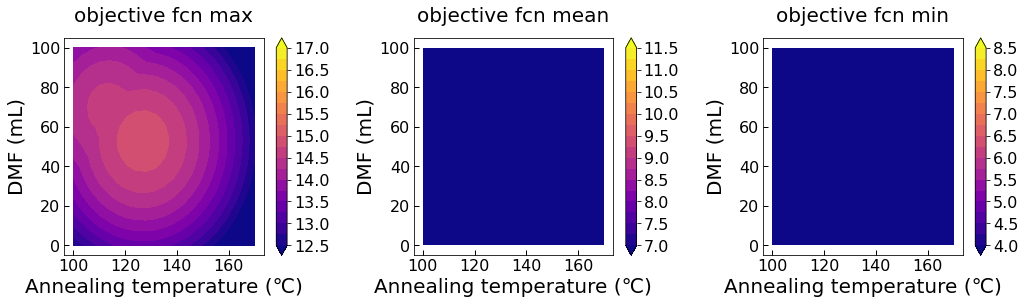

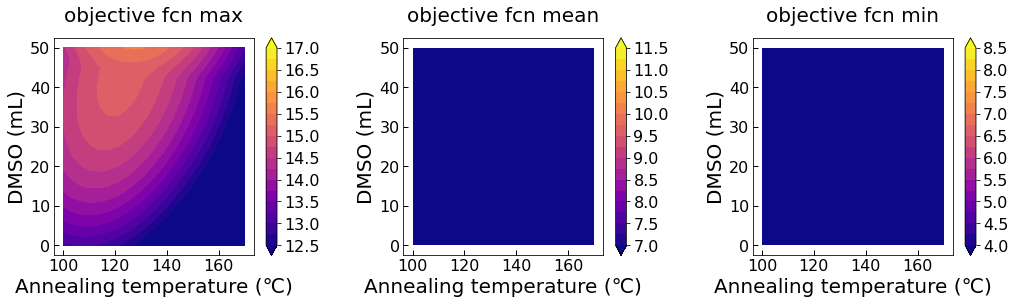

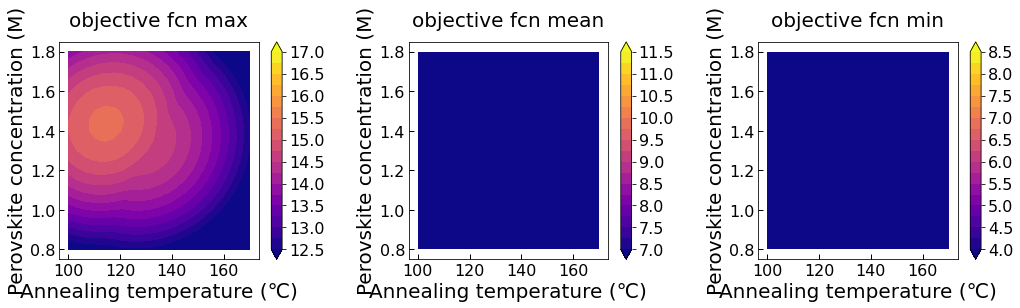

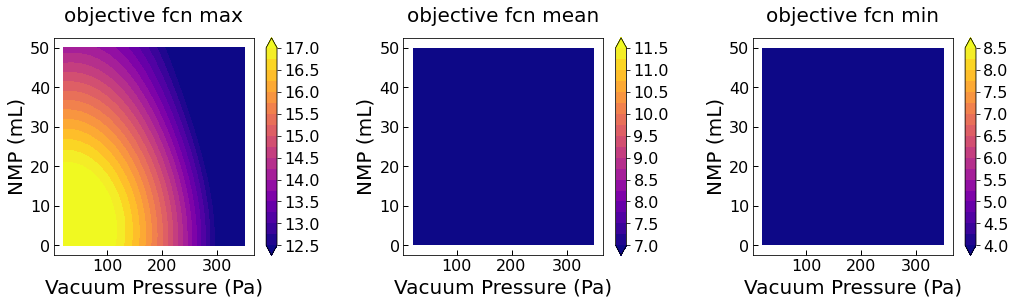

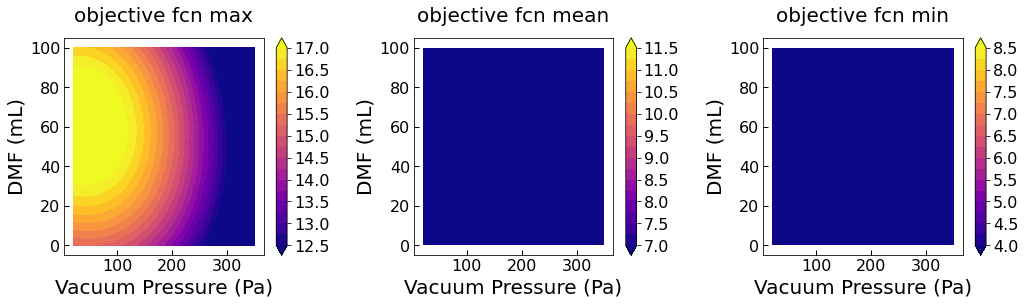

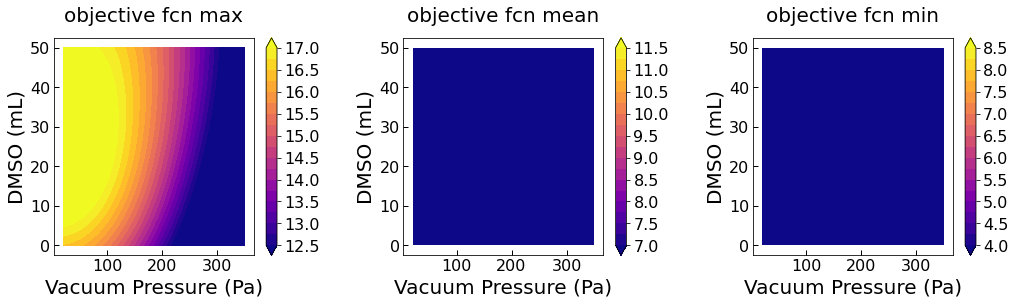

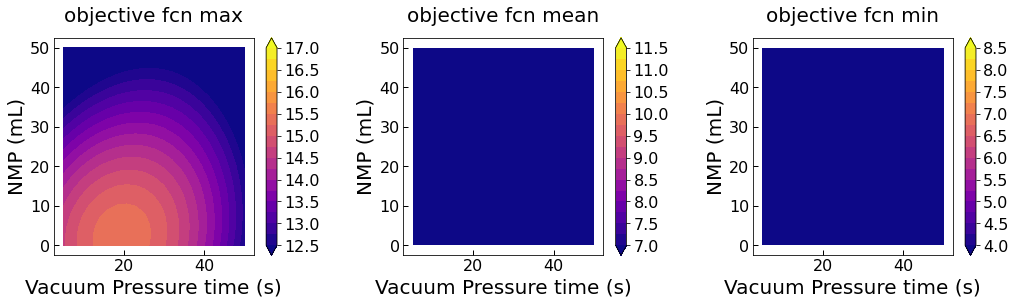

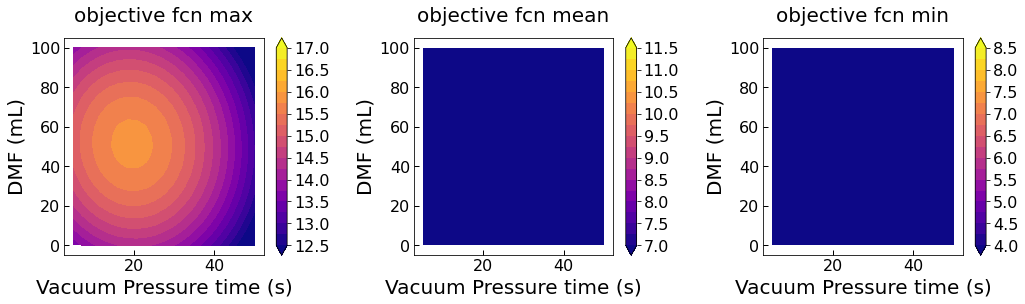

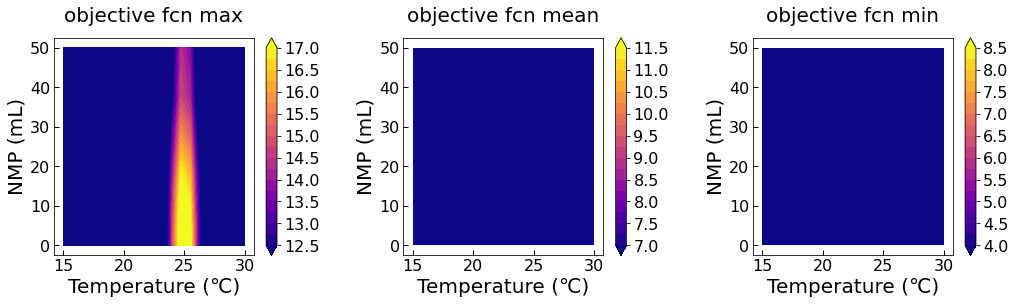

In [15]:
design = RandomDesign(parameter_space)
x_sampled = design.get_samples(1000)
x_columns = df_device.iloc[:,1 :10].columns

for i in range(input_dim):
    for j in range(input_dim-i-1):
        if i != j:
            generate_contour_plot(i, j, x_sampled, f_obj, x_descaler, x_columns, var_array)